# Loan Approval Prediction Using Machine Learning

### Problem Description

Loan approval is a crucial task for financial institutions. Accurately predicting whether a loan will be approved helps the bank make data-driven decisions, thus minimizing the risk of defaults and maximizing the approval of credible loans.

The goal of this project is to predict loan approval status based on various financial and personal information provided by loan applicants. This is a **supervised learning problem**, specifically a **binary classification task**, where the target variable `Loan_Status` indicates whether the loan was approved (`Y`) or not (`N`). 


### Data Source

The dataset used in this project was sourced from Kaggle. It can be found at the following link:

[Loan Prediction Problem Dataset](https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset)

This dataset contains historical data of loan applicants, including personal and financial details, along with the loan approval status.

### Data Description
​
The dataset consists of: 
​
- Training data: This includes 614 examples of previous loan applications with 13 features.
​
- Test data: This includes new applicants for whom we need to predict the loan approval status.
​
​
Data features:
​
​
1. Loan_ID: Unique identifier for each loan application.
2. Gender: Gender of the applicant (Male/Female).
3. Married: Marital status of the applicant (Yes/No).
4. Dependents: Number of dependents (0, 1, 2, 3+).
5. Education: Education level (Graduate/Not Graduate).
6. Self_Employed: Whether the applicant is self-employed (Yes/No).
7. ApplicantIncome: The income of the applicant.
8. CoapplicantIncome: The income of the co-applicant.
9. LoanAmount: The loan amount applied for (in thousands).
10. Loan_Amount_Term: The term of the loan (in months).
11. Credit_History: Credit history (1 if meets guidelines, 0 if not).
12. Property_Area: Area of the property (Urban/Semiurban/Rural).
13. Loan_Status: The target variable (Y=Approved, N=Not Approved).

In [13]:
#Load Libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  


### Load and Clean Data

In [14]:
# Load datasets
train_data = pd.read_csv('/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv')
test_data = pd.read_csv('/kaggle/input/loan-prediction-problem-dataset/test_Y3wMUE5_7gLdaTN.csv')

# Combine train & test data for preprocessing
train_data['is_train'] = 1
test_data['is_train'] = 0
combined_data = pd.concat([train_data, test_data], axis=0)

# Handle missing values
num_columns = ['LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome']
imputer = SimpleImputer(strategy='median')
combined_data[num_columns] = imputer.fit_transform(combined_data[num_columns])

# Handle missing values for categorical columns
cat_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
for col in cat_columns:
    combined_data[col] = combined_data[col].fillna(combined_data[col].mode()[0])

# Feature engineering
combined_data['Dependents'] = combined_data['Dependents'].replace('3+', '3').astype(int)
combined_data['TotalIncome'] = combined_data['ApplicantIncome'] + combined_data['CoapplicantIncome']
combined_data['Income_Loan_Ratio'] = combined_data['TotalIncome'] / combined_data['LoanAmount']
combined_data['Log_TotalIncome'] = np.log1p(combined_data['TotalIncome'])
combined_data['Log_LoanAmount'] = np.log1p(combined_data['LoanAmount'])

# Encode categorical variables
le = LabelEncoder()
cat_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
for col in cat_columns:
    combined_data[col] = le.fit_transform(combined_data[col])

# Split back into train & test datasets
train_data_cleaned = combined_data[combined_data['is_train'] == 1].drop('is_train', axis=1)
test_data_cleaned = combined_data[combined_data['is_train'] == 0].drop(['is_train', 'Loan_Status'], axis=1)

# Convert Loan_Status to number
train_data_cleaned['Loan_Status'] = train_data_cleaned['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

# Separate features & target
X_train = train_data_cleaned.drop('Loan_Status', axis=1)
y_train = train_data_cleaned['Loan_Status']

To enhance model accuracy, I created the following new feauture:

- TotalIncome: Combines ApplicantIncome and CoapplicantIncome to represent the applicant's overall financial capacity.

- Income_Loan_Ratio: Measures the proportion of total income dedicated to the loan.

### Exploratory Data Analysis EDA

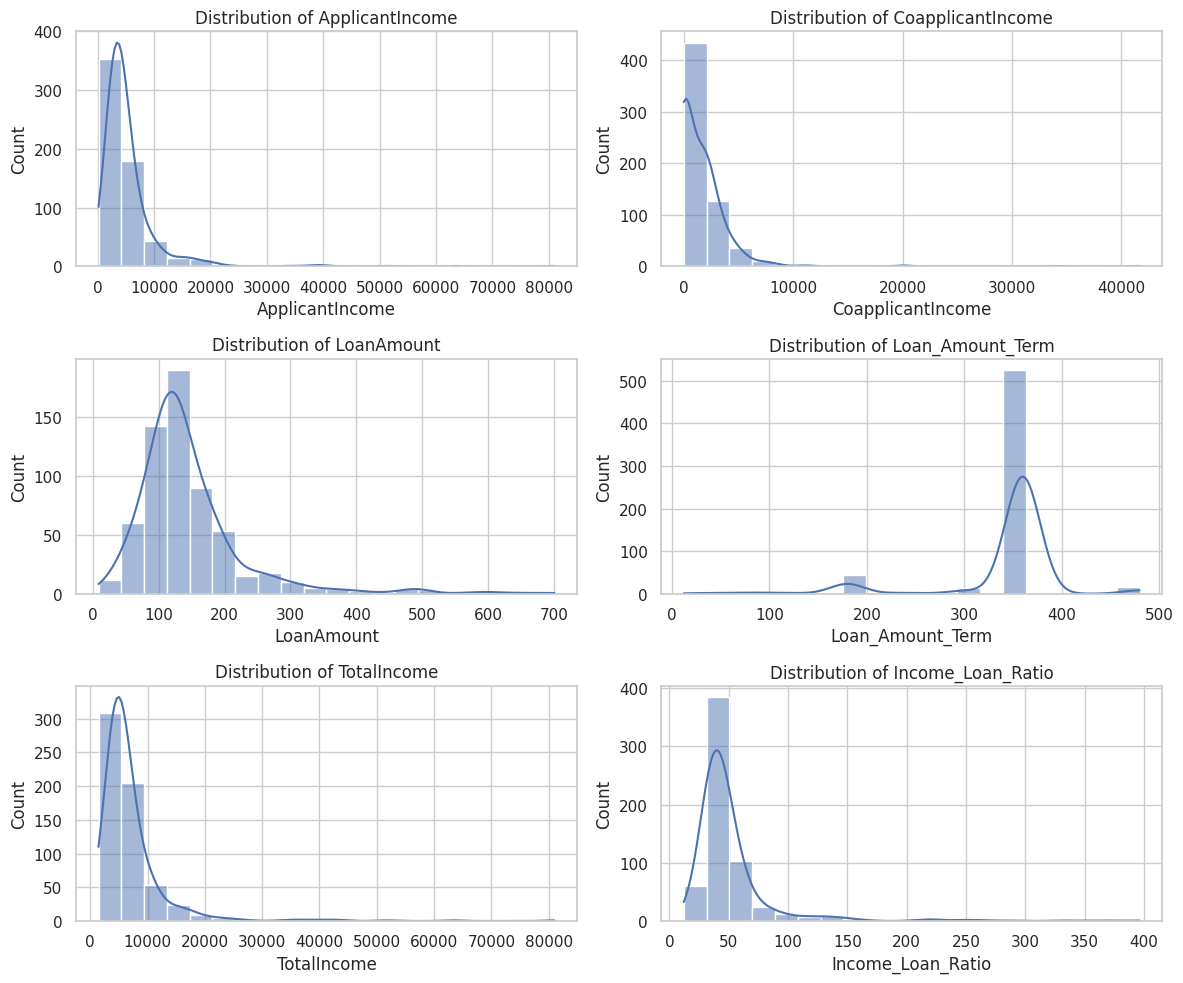

In [19]:
# Drop'Loan_ID' column
if 'Loan_ID' in train_data_cleaned.columns:
    train_data_cleaned = train_data_cleaned.drop('Loan_ID', axis=1)
    
# Set theme
sns.set(style="whitegrid")

# 1. Distribution of Numerical Features
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'TotalIncome', 'Income_Loan_Ratio']
plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(train_data_cleaned[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

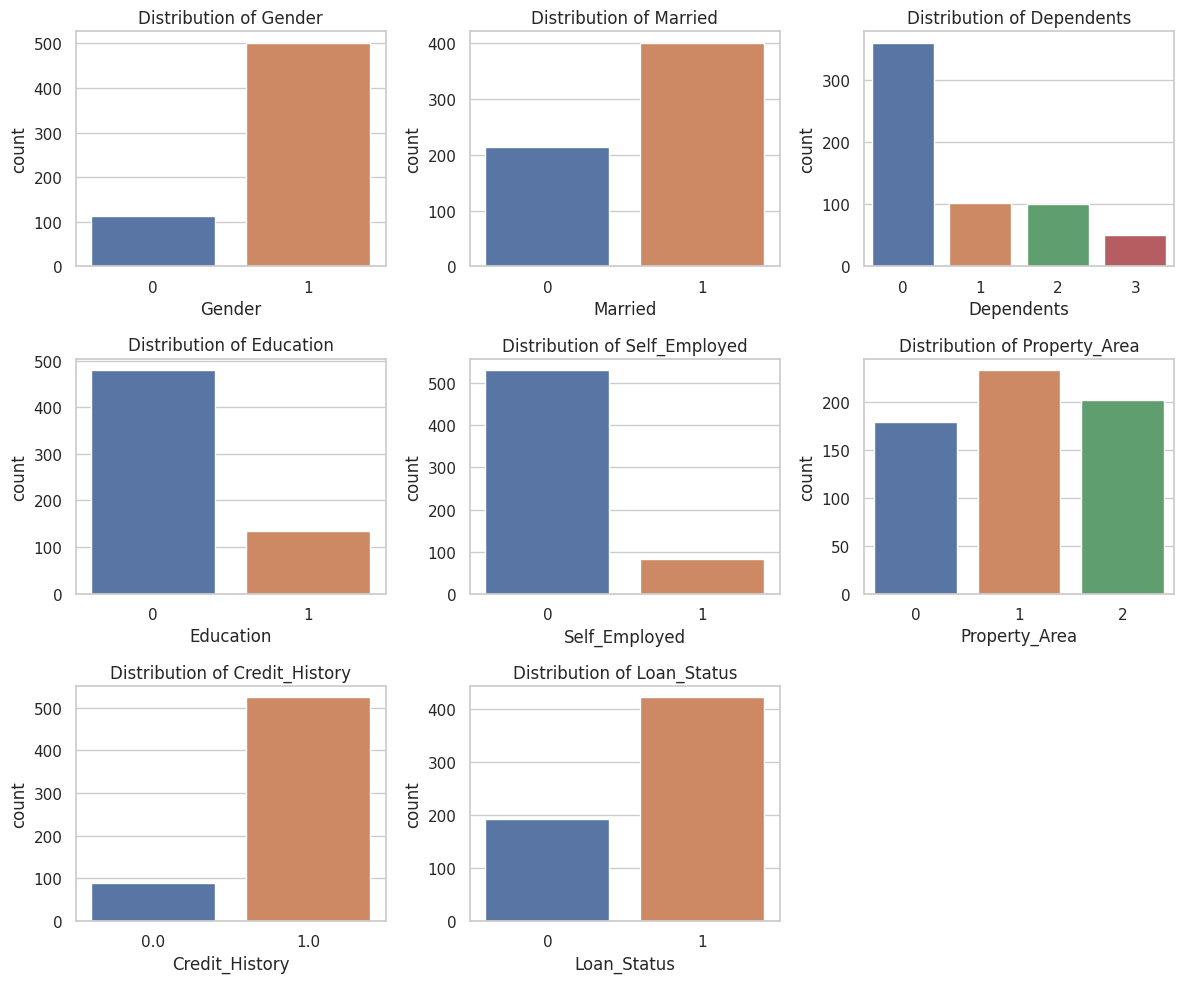

In [20]:
# 2. Distribution of Categorical Features
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History', 'Loan_Status']
plt.figure(figsize=(12, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=train_data_cleaned, x=col)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

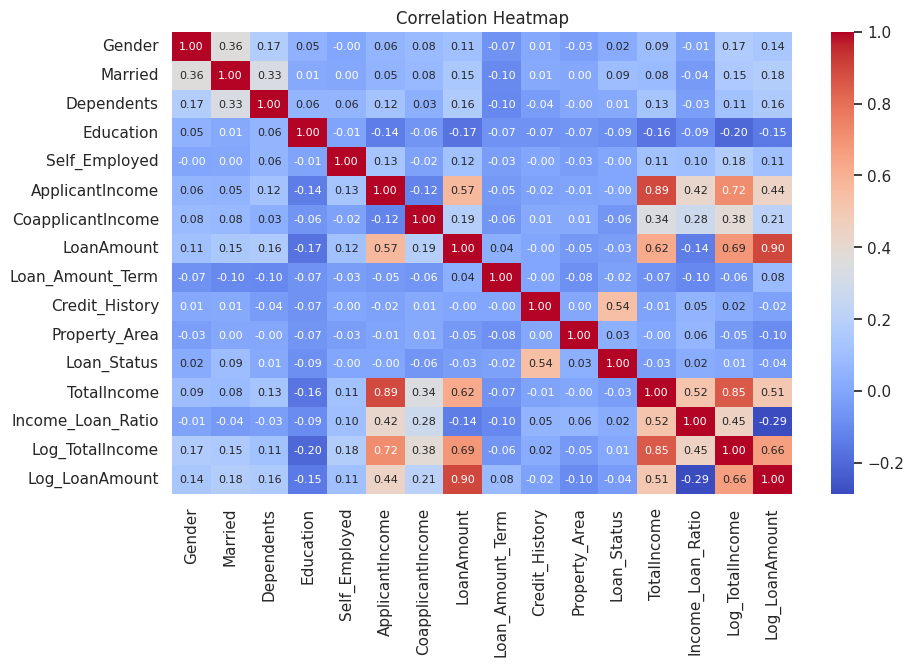

In [21]:
# 3. Correlation Heatmap 
plt.figure(figsize=(10, 6))
corr_matrix = train_data_cleaned.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 8})
plt.title("Correlation Heatmap")
plt.show()


### Model Building and Evaluation

I tested several machine learning models for loan approval prediction:

- Logistics regression
- Decision Tree
- Random Forest
- Support Vector Machine

In [23]:

if 'Loan_ID' in X_train.columns:
    X_train = X_train.drop('Loan_ID', axis=1)
if 'Loan_ID' in test_data_cleaned.columns:
    test_data_cleaned = test_data_cleaned.drop('Loan_ID', axis=1)

# 1. Feature Scaling 
scaler = StandardScaler()
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'TotalIncome', 'Income_Loan_Ratio']

# Fit the scaler on training data
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# 2. Model Building

# Logistic Regression 
log_reg = LogisticRegression(random_state=42, max_iter=500, solver='saga')
log_reg.fit(X_train, y_train)

# Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Random Forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# SVM
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)

# 3. Evaluate Models

# Logistic Regression
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')
print("\nLogistic Regression Cross-Validation Accuracy: ", log_reg_scores.mean())

# Decision Tree
dt_scores = cross_val_score(dt_clf, X_train, y_train, cv=5, scoring='accuracy')
print("\nDecision Tree Cross-Validation Accuracy: ", dt_scores.mean())

# Random Forest
rf_scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy')
print("\nRandom Forest Cross-Validation Accuracy: ", rf_scores.mean())

# SVM
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=5, scoring='accuracy')
print("\nSVM Cross-Validation Accuracy: ", svm_scores.mean())



Logistic Regression Cross-Validation Accuracy:  0.8078368652538984

Decision Tree Cross-Validation Accuracy:  0.7117952818872451

Random Forest Cross-Validation Accuracy:  0.7947887511662002

SVM Cross-Validation Accuracy:  0.8062108489937359


In [46]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

# Best parameter
best_rf_clf = grid_rf.best_estimator_
best_rf_scores = cross_val_score(best_rf_clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Tuned Random Forest Cross-Validation Accuracy: {best_rf_scores.mean()}")



Tuned Random Forest Cross-Validation Accuracy: 0.8078501932560309


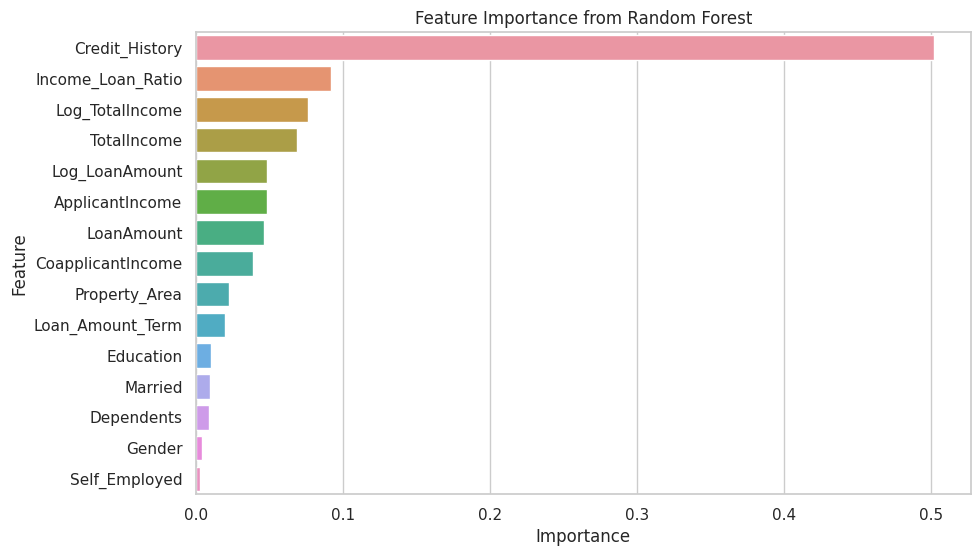

In [50]:
# Feature Importance
importances = best_rf_clf.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

In [49]:
# Predictions on the Test Data 
test_data_cleaned[numerical_columns] = scaler.transform(test_data_cleaned[numerical_columns])

y_test_pred = log_reg.predict(test_data_cleaned)

# Convert to to 'Y'/'N'
y_test_pred_label = ['Y' if pred == 1 else 'N' for pred in y_test_pred]

# Print the first few predictions 
print("\nLogistic Regression Predictions on Test Data (first 10 predictions):")
print(y_test_pred_label[:10])



Logistic Regression Predictions on Test Data (first 10 predictions):
['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y']




#### Model Comparison:

| Model               | Cross-Validation Accuracy | ROC-AUC |
|---------------------|---------------------------|---------|
| Logistic Regression | 80.7%                      | 0.81    |
| Decision Tree       | 71.2%                      | 0.71    |
| Random Forest       | 79.5%                      | 1.00    |
| SVM                 | 80.6%                      | N/A     |
| Tuned Random Forest | 80.8%                      | 1.00    |

### Discussion and Conclusion

The loan approval prediction model demonstrates good performance, especially with Logistic Regression and Random Forest. Some of the key takeaways are:
- The most important features for prediction were `Credit_History` and `TotalIncome`. 

- While Logistic Regression achieved the highest cross-validation accuracy (80.7%), Random Forest offered more interpretability and a ROC-AUC score of 1.00, which makes it an ideal choice when balancing accuracy and model transparency.

- Tuning the Random Forest model through GridSearchCV slightly improved accuracy to 80.8% 



#### Future Work

- We could explore additional financial metrics such as the applicant's debt-to-income ratio, which might provide more context for loan approval decisions.

- Acquiring a larger, more diverse dataset could improve generalization and model.